In [44]:
import bayesadam.adasghmc as ba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch
import tqdm



In [32]:
def double_well_potential(x, y):
    return (x**2 - 1)**2 + (y**2 - 1)**2

In [33]:
# Set the range and resolution for the grid
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)

# Create a meshgrid
X, Y = np.meshgrid(x, y)

# Compute the potential on the grid
Z = double_well_potential(X, Y)

# Flatten the grids and potentials for KDE
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Normalize the potential values to probabilities for KDE input
z_prob = np.exp(-z_flat) / np.sum(np.exp(-z_flat))

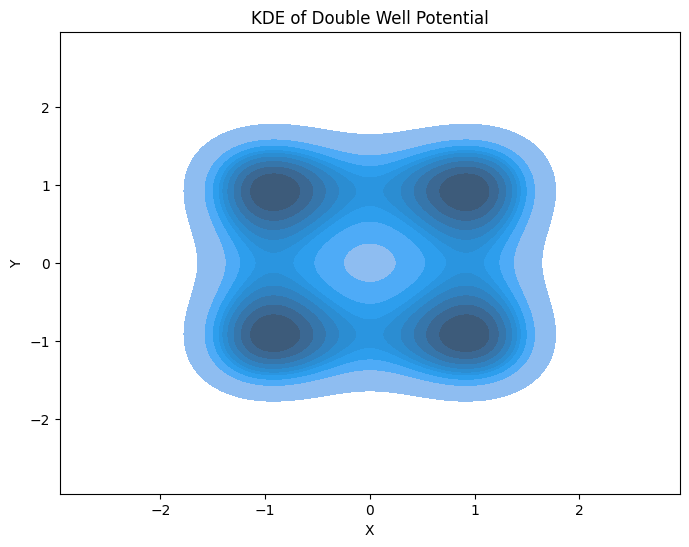

In [34]:
# Use seaborn to create a KDE plot
plt.figure(figsize=(8, 6))
sns.kdeplot(x=x_flat, y=y_flat, weights=z_prob, fill=True)
plt.title('KDE of Double Well Potential')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [35]:
# Initialize parameters
x = torch.tensor([2.0, 2.0], requires_grad=True)

# Define the AdaSGHMC optimizer
optimizer = ba.AdaSGHMC([x], learning_rate=0.03, gradient_ema=0.9999, momentum=0.9, eps=1e-8)

# Define a closure to compute the potential and its gradient
def closure():
    optimizer.zero_grad()
    potential = double_well_potential(x[0],x[1])
    potential.backward()
    return potential

# Sample from the potential
samples = []
n_samples = 500000
burn_in = 5000
skip = 100
for i in tqdm.tqdm(range(n_samples)):
    optimizer.step(closure)
    if i >= burn_in and i % skip == 0:
        samples.append(x.detach().numpy().copy())

# Convert samples to a numpy array for plotting
samples = np.array(samples)

100%|██████████████████████████████████████████████| 500000/500000 [06:48<00:00, 1222.70it/s]


Text(0, 0.5, 'Y')

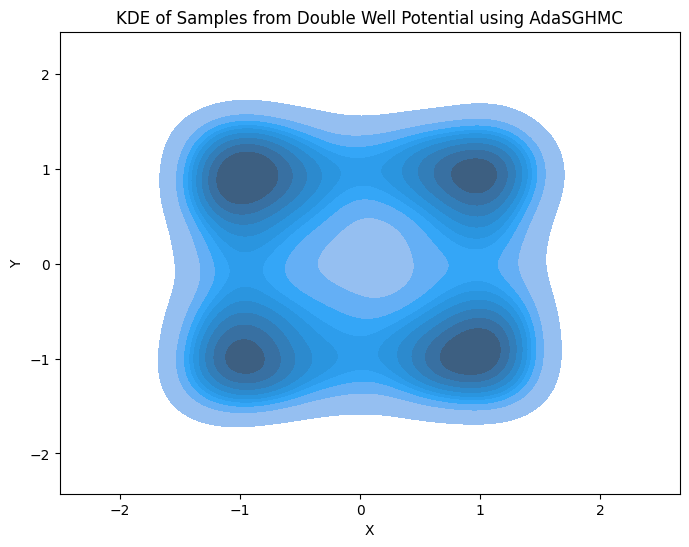

In [36]:
# Plot the sampled distribution using KDE
plt.figure(figsize=(8, 6))
sns.kdeplot(x=samples[:, 0], y=samples[:, 1], fill=True)
plt.title('KDE of Samples from Double Well Potential using AdaSGHMC')
plt.xlabel('X')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


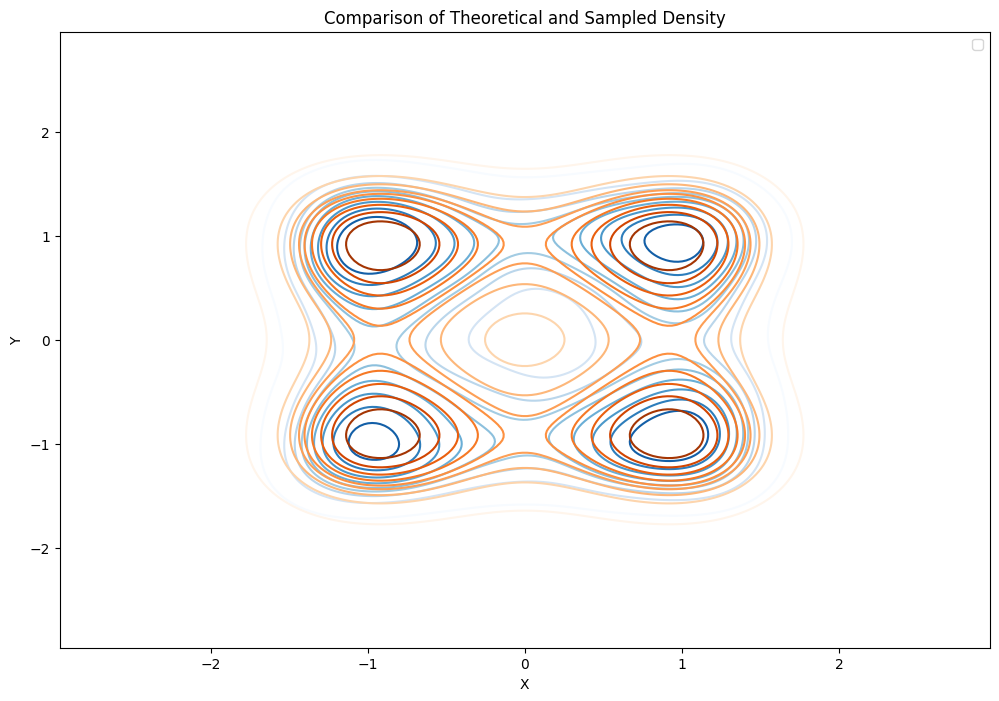

In [42]:
# Plot both densities
plt.figure(figsize=(12, 8))
sns.kdeplot(x=samples[:, 0], y=samples[:, 1], fill=False, levels=10, cmap="Blues", alpha=1, label='AdaSGHMC Samples')
sns.kdeplot(x=x_flat, y=y_flat, weights=z_prob, fill=False, levels=10, cmap="Oranges", alpha=1, label='Theoretical Density')
plt.title('Comparison of Theoretical and Sampled Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

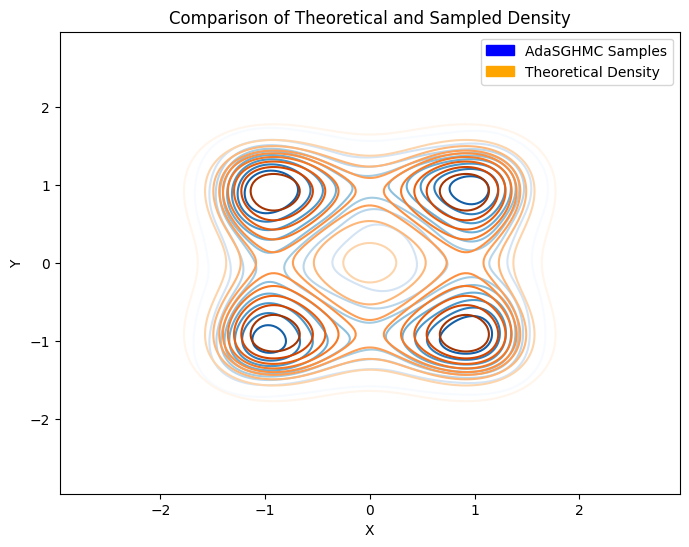

In [46]:
# Plot both densities
plt.figure(figsize=(8, 6))

# KDE plot for AdaSGHMC samples
sns.kdeplot(x=samples[:, 0], y=samples[:, 1], fill=False, levels=10, cmap="Blues", alpha=1)

# KDE plot for theoretical density
sns.kdeplot(x=x_flat, y=y_flat, weights=z_prob, fill=False, levels=10, cmap="Oranges", alpha=1)

# Create a legend manually
blue_patch = mpatches.Patch(color='blue', label='AdaSGHMC Samples')
orange_patch = mpatches.Patch(color='orange', label='Theoretical Density')
plt.legend(handles=[blue_patch, orange_patch])

plt.title('Comparison of Theoretical and Sampled Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [109]:
import zipfile
import os
import random
import requests
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from x_transformers import TransformerWrapper, Decoder, AutoregressiveWrapper
from bayesadam.adasghmc import AdaSGHMC  # Assuming this is how it's imported based on your structure

In [95]:
class CharLevelDataset(Dataset):
    def __init__(self, file_path, sequence_length=512, train_split=0.8):
        with open(file_path, 'rb') as file:
            self.data = np.frombuffer(file.read(), dtype=np.uint8)  # Read the entire file as a byte array
        self.sequence_length = sequence_length
        self.train_split = train_split

        # Total number of sequences
        total_sequences = len(self.data) // sequence_length
        self.train_size = int(total_sequences * train_split)
        self.validation_size = total_sequences - self.train_size
        
        # Creating mask for the entire dataset
        self.mask = np.random.rand(len(self.data)) < train_split

    def __len__(self):
        return len(self.data) // self.sequence_length

    def __getitem__(self, idx):
        start_idx = idx * self.sequence_length
        end_idx = start_idx + self.sequence_length + 1  # +1 to include the target character

        inputs = torch.tensor(self.data[start_idx:end_idx - 1], dtype=torch.long)
        targets = torch.tensor(self.data[start_idx + 1:end_idx], dtype=torch.long)
        
        # Generate mask for current sequence
        mask = torch.tensor(self.mask[start_idx + 1:end_idx], dtype=torch.bool)

        return inputs, targets, mask  # Return input, target sequences and mask

    def train_characters(self):
        return self.train_size * self.sequence_length

    def validation_characters(self):
        return self.validation_size * self.sequence_length

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)  # Optionally remove the zip file after extraction

def download_dataset(url, save_path):
    """Download and save the dataset if not exists."""
    if not os.path.exists(save_path):
        print("Downloading dataset...")
        response = requests.get(url)
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print("Dataset downloaded and saved to", save_path)
    else:
        print("Dataset already exists at", save_path)

def get_data_loader(data_dir, batch_size=16, sequence_length=512):
    data_path = os.path.join(data_dir, 'enwik8')

    dataset = CharLevelDataset(data_path, sequence_length)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

In [77]:
zip_path = "/tmp/enwik8.zip"
data_dir = "/tmp/enwik8"
batch_size = 16
sequence_length = 512

In [78]:
download_dataset("https://mattmahoney.net/dc/enwik8.zip",zip_path)
unzip_file(zip_path, data_dir)

Dataset downloaded and saved to /tmp/enwik8.zip


In [96]:
data_loader = get_data_loader(data_path, batch_size, sequence_length)

In [91]:
# Create the model for character-level language modeling
def create_model(num_tokens=256):
    model = TransformerWrapper(
        num_tokens=num_tokens,
        max_seq_len=512,
        attn_layers=Decoder(
            dim=128,
            depth=6,  # Reduced depth for demonstration
            heads=8,
        )
    )
    return model

In [127]:
def train_model(model, optimizer, data_loader, epochs=10, device='cuda', l2_lambda=0.01):
    model.to(device)
    validation_losses = []

    num_batches = len(data_loader)  # Total number of batches, used to scale the loss

    for epoch in range(epochs):
        model.train()

        # Iterate over batches
        data = list(data_loader)
        random.shuffle(data)
        for i,(inputs, targets, mask) in enumerate(data):
            inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
            train_mask = mask.bool()
            val_mask = ~train_mask

            # Forward pass
            logits = model(inputs)
            logits_transposed = logits.transpose(1, 2)  # Logits need to be (N, C, L)

            # Calculate loss for all to apply masks correctly
            loss = F.cross_entropy(logits_transposed, targets, reduction='none')

            # Masked losses for training and validation
            train_loss = loss * train_mask.float()
            val_loss = loss * val_mask.float()

            # Calculate mean of the training loss and sum the validation loss
            sum_train_loss = train_loss.sum()
            mean_val_loss = val_loss.sum() / val_mask.float().sum()  # Normalize by the number of validation items

            # Scale the training loss by the number of batches before L2 penalty
            scaled_train_loss = sum_train_loss * num_batches

            # Add L2 penalty to scaled training loss
            l2_penalty = sum(p.pow(2.0).sum() for p in model.parameters())
            total_loss = scaled_train_loss + l2_lambda * l2_penalty

            # Backward and optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Training Loss: {scaled_train_loss}, Validation Loss: {mean_val_loss.item()}, Iteration: {i}/{num_batches}")
                validation_losses.append(mean_val_loss.item())

    return validation_losses

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate models
adam_model = create_model().to(device)
adasghmc_model = create_model().to(device)

# Optimizers
adam_optimizer = Adam(adam_model.parameters(), lr=0.001)
adasghmc_optimizer = AdaSGHMC(adasghmc_model.parameters(), learning_rate=0.001, gradient_ema=0.99, momentum=0.9, eps=1e-8)

# Train models
print("Training model with Adam")
validation_loss_adam = train_model(adam_model, adam_optimizer, data_loader, epochs=1, device='cuda', l2_lambda=0.01)

print("Training model with AdaSGHMC")
validation_loss_adasghmc = train_model(adasghmc_model, adasghmc_optimizer, data_loader, epochs=1, device='cuda', l2_lambda=0.01)

Training model with Adam
Epoch 0/1, Training Loss: 471561888.0, Validation Loss: 5.884599208831787, Iteration: 0/12207
Epoch 0/1, Training Loss: 222833200.0, Validation Loss: 2.846797227859497, Iteration: 100/12207
Epoch 0/1, Training Loss: 217026064.0, Validation Loss: 2.6656887531280518, Iteration: 200/12207
Epoch 0/1, Training Loss: 207492320.0, Validation Loss: 2.5461297035217285, Iteration: 300/12207
Epoch 0/1, Training Loss: 198926352.0, Validation Loss: 2.5004637241363525, Iteration: 400/12207
Epoch 0/1, Training Loss: 202535952.0, Validation Loss: 2.6297621726989746, Iteration: 500/12207
Epoch 0/1, Training Loss: 196477520.0, Validation Loss: 2.4449803829193115, Iteration: 600/12207
Epoch 0/1, Training Loss: 193106368.0, Validation Loss: 2.329930305480957, Iteration: 700/12207
Epoch 0/1, Training Loss: 182784160.0, Validation Loss: 2.347827196121216, Iteration: 800/12207
Epoch 0/1, Training Loss: 159085136.0, Validation Loss: 1.9770771265029907, Iteration: 900/12207
Epoch 0/1, 

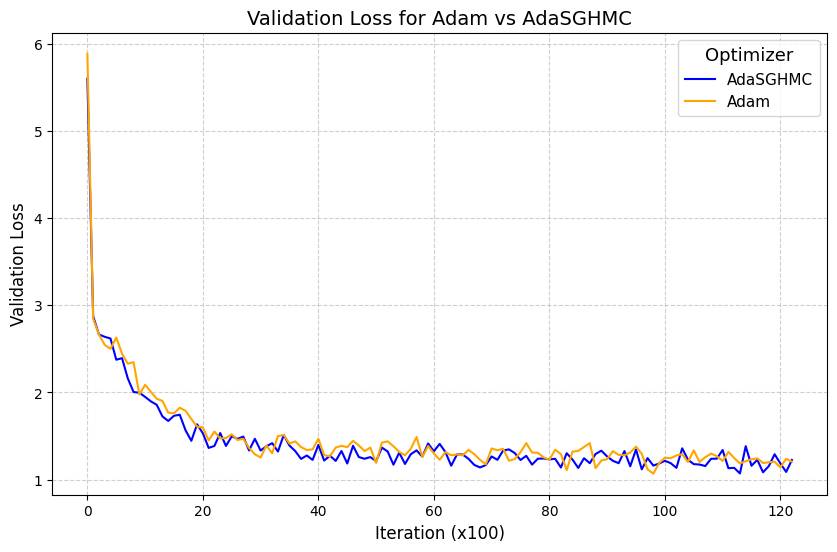

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Plotting the data
plt.plot(validation_loss_adasghmc, label='AdaSGHMC', color='blue')
plt.plot(validation_loss_adam, label='Adam', color='orange')

# Adding labels and title
plt.xlabel('Iteration (x100)', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Validation Loss for Adam vs AdaSGHMC', fontsize=14)

# Adding a legend
plt.legend(title='Optimizer', title_fontsize='13', fontsize='11')

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Optionally, setting a logarithmic scale for y-axis if the data spans several orders of magnitude
# plt.yscale('log')

plt.show()